In [3]:
in_path =r'../../data/clean/' # use your path
out_path=r'../../data/clean/'

import pandas as pd
pd.set_option('display.max_columns', 500)
import glob
import re
from nltk import stem
porter = stem.porter.PorterStemmer()
from gensim import corpora, models, similarities
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
    df=pd.read_csv(in_path+"articles.csv")   
    df.DE.fillna('',inplace=True)
    df['doc']=df.AB+'. '+df.TI+'. '+df.DE

In [5]:
    docs_csv=out_path+"docs.csv"
    df.doc.to_csv(docs_csv, index=False)
    
    with open(docs_csv) as f:
        docs = f.readlines()

In [6]:
    docs_cleaned = [[re.sub('[.!,;?()\W\d]+', '', word) for word in doc.lower().split()] for doc in docs]
    stop= open ('stopList.txt').read()
    stop_list = set(stop.replace("\n", " ").split())
    docs_stemed = [[porter.stem(word) for word in document if word not in stop_list] for document in docs_cleaned]
    docs_prepared=out_path+'docs_prepared.csv'
    with open(docs_prepared, 'w') as f:
        for doc in docs_stemed:f.write("%s\n" % ' '.join(doc))        

In [7]:
dictionary = corpora.Dictionary(docs_stemed)
dictionary.filter_extremes(no_below=5)
dictionary.compactify() 
print dictionary

class MyCorpus(object):
    def __iter__(self):
        for doc in docs_stemed:
            yield dictionary.doc2bow(doc)
corpus= MyCorpus() 
corpora.MmCorpus.serialize('serialized.mm', corpus)
corpus = corpora.MmCorpus('serialized.mm')
print corpus

Dictionary(2634 unique tokens: [u'', u'assimil', u'interchang', u'articul', u'payoff']...)
MmCorpus(2101 documents, 2634 features, 130884 non-zero entries)


In [8]:
    tfidf = models.tfidfmodel.TfidfModel(corpus)
    corpus_tfidf = tfidf[corpus]
    lsi = models.LsiModel(corpus_tfidf, id2word=dictionary, num_topics=100) 
    corpus_lsi=lsi[corpus_tfidf]

    index = similarities.MatrixSimilarity(corpus_lsi) 
    lines = docs_stemed
    sims = open('../csv/lsi.csv', 'w')
    sims.write('source,target,weight,type\n')
    for i in range(len(docs_stemed)):
        doc=lines[i]    
        vec_bow = dictionary.doc2bow(doc)
        vec_tran = lsi[tfidf[vec_bow]]
        #vec_tran = lda[tfidf[vec_bow]]
        simsinx = index[vec_tran]
        for j in range(i+1,len(simsinx)):
            if simsinx[j]>.5:                                        
                sims.write(str(i)+','+str(j)+','+str(simsinx[j])+',undirected\n')
    sims.close()

In [53]:
lsi_df=pd.read_csv('../csv/lsi.csv')
lsi_df=lsi_df[lsi_df.weight>.5]
lsi_df.shape

(24434, 4)

In [69]:
n=max(lsi_df.source.max(),lsi_df.target.max())
mm=np.zeros((n+1,n+1))
mm.shape

(2101L, 2101L)

In [70]:
for row in lsi_df.iterrows():
    mm[row[1][0],row[1][1]]=row[1][2]

In [71]:
mm

array([[ 0.      ,  0.690299,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       ..., 
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ],
       [ 0.      ,  0.      ,  0.      , ...,  0.      ,  0.      ,  0.      ]])

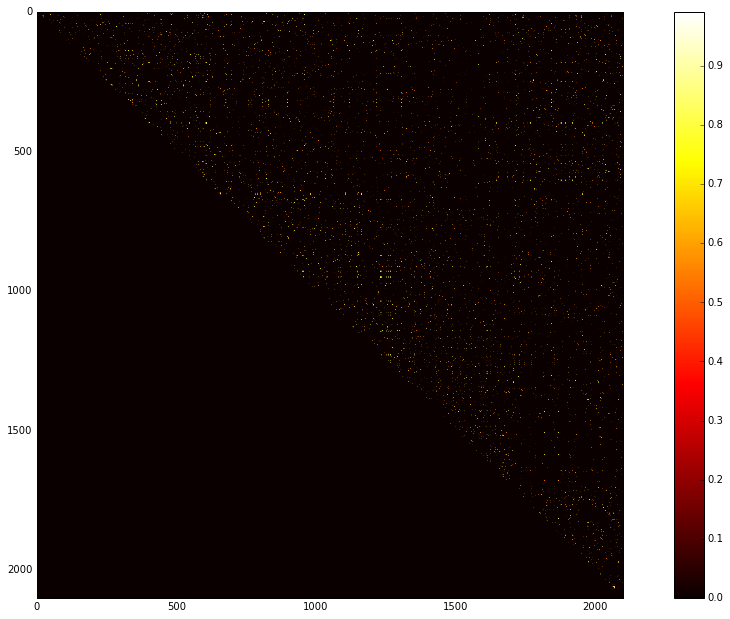

In [73]:
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5, forward=True)
plt.imshow(mm, cmap=plt.cm.hot)
plt.colorbar()
plt.show()

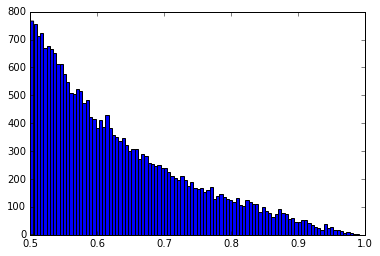

In [10]:
import numpy as np
l=lsi_df.weight
hist=plt.hist(l,101)

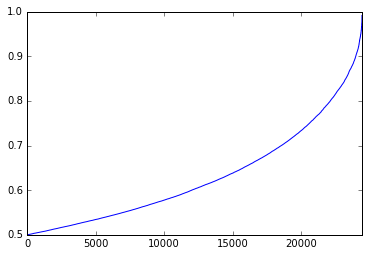

In [11]:
l=l.sort_values()
l=l.reset_index(drop=True)
l.plot(drawstyle='steps')

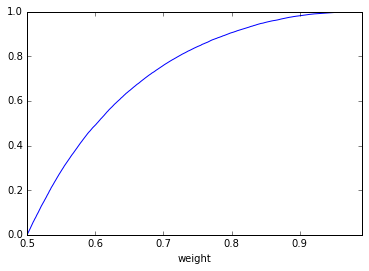

In [12]:
cum_dist = np.linspace(0.,1.,len(l))
cdf = pd.Series(cum_dist, index=l)
cdf.plot()

In [13]:
dic=cdf.to_dict()
lsi_df['p']=lsi_df.weight.apply(lambda x :1- dic[x])

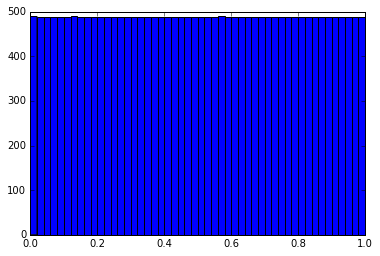

In [14]:
p=lsi_df.p
binwidth=.01
hist=plt.hist(p,50 )

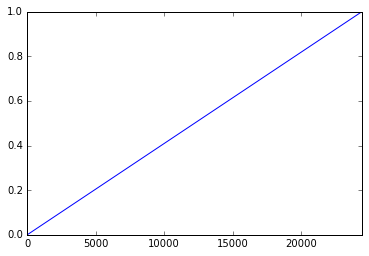

In [15]:
p=lsi_df.p
p=p.sort_values()
p=p.reset_index(drop=True)
p.plot(drawstyle='steps')

In [16]:
lsi_df['original_weight']=lsi_df.weight
lsi_df.drop('weight',inplace=True,axis=1)
lsi_df['weight']=1-lsi_df.p
lsi_df[['source','target','weight','type']].to_csv('../csv/p_lsi.csv',index=False)

In [17]:
lsi_df.shape

(24434, 6)

In [48]:
df[df.index==341]

Unnamed: 0 ﻿PT                                AU  BA  BE  GP  \
341         341   J  Lahiri, A; Dewan, RM; Freimer, M NaN NaN NaN   

                                                    AF  BF  CA  \
341  Lahiri, Atanu; Dewan, Rajiv M.; Freimer, Marshall NaN NaN   

                                                    TI  \
341  The Disruptive Effect of Open Platforms on Mar...   

                                            SO  SE  BS       LA       DT   CT  \
341  JOURNAL OF MANAGEMENT INFORMATION SYSTEMS NaN NaN  English  Article  NaN   

      CY   CL   SP   HO                                                 DE  \
341  NaN  NaN  NaN  NaN  net neutrality; nonlinear pricing; open platfo...   

                              ID  \
341  INFORMATION GOODS; MONOPOLY   

                                                    AB  \
341  Application-based pricing is common in telecom...   

                                                    C1  \
341  [Lahiri, Atanu] Univ Washington, Foster Sch Bu...   

                                                    RP   EM   RI   OI   FU  \
341  Lahiri, A (reprint author), Univ Washington, F...  NaN  NaN  NaN  NaN   

      FX                                                 CR  NR  TC  Z9  U1  \
341  NaN  ADAMS WJ, 1976, Q J ECON, V90, P475, DOI 10.23...  17   1   1   2   

     U2              PU      PI                                         PA  \
341  12  M E SHARPE INC  ARMONK  80 BUSINESS PARK DR, ARMONK, NY 10504 USA   

            SN         EI  BN                    J9                        JI  \
341  0742-1222  1557-928X NaN  J MANAGE INFORM SYST  J. Manage. Inform. Syst.   

      PD    PY  VL   IS  PN  SU   SI  MA  BP   EP  AR  \
341  WIN  2010  27  3.0 NaN NaN  NaN NaN  81  109 NaN   

                             DI  D2  PG  \
341  10.2753/MIS0742-1222270304 NaN  29   

                                                    WC  \
341  Computer Science, Information Systems; Informa...   

                                                    SC     GA  \
341  Computer Science; Information Science & Librar...  738JC   

                      UT  PM   id  \
341  WOS:000288635100005 NaN  341   

                                                   doc  
341  Application-based pricing is common in telecom...

In [47]:
df[df.index==2089]

Unnamed: 0 ﻿PT                                AU  BA  BE  GP  \
2089        2089   J  Lahiri, A; Dewan, RM; Freimer, M NaN NaN NaN   

                                                     AF  BF  CA  \
2089  Lahiri, Atanu; Dewan, Rajiv M.; Freimer, Marshall NaN NaN   

                                                     TI  \
2089  Pricing of Wireless Services: Service Pricing ...   

                                SO  SE  BS       LA       DT   CT   CY   CL  \
2089  INFORMATION SYSTEMS RESEARCH NaN NaN  English  Article  NaN  NaN  NaN   

       SP   HO                                                 DE  \
2089  NaN  NaN  nonlinear pricing; second-degree discriminatio...   

                                                     ID  \
2089  INFORMATION GOODS; MONOPOLY; WELFARE; DISCRIMI...   

                                                     AB  \
2089  As the ability to measure technology resource ...   

                                                     C1  \
2089  [Lahiri, Atanu] Univ Washington, Michael G Fos...   

                                                     RP  \
2089  Lahiri, A (reprint author), Univ Washington, M...   

                                                     EM   RI   OI   FU   FX  \
2089  lahiria@uw.edu; dewan@simon.rochester.edu; fre...  NaN  NaN  NaN  NaN   

                                                     CR  NR  TC  Z9  U1  U2  \
2089  ADAMS WJ, 1976, Q J ECON, V90, P475, DOI 10.23...  38   6   6   2  25   

           PU           PI                                                 PA  \
2089  INFORMS  CATONSVILLE  5521 RESEARCH PARK DR, SUITE 200, CATONSVILLE,...   

             SN         EI  BN               J9               JI   PD    PY  \
2089  1047-7047  1526-5536 NaN  INFORM SYST RES  Inf. Syst. Res.  JUN  2013   

      VL   IS  PN  SU   SI  MA   BP   EP  AR                      DI  D2  PG  \
2089  24  2.0 NaN NaN  NaN NaN  418  435 NaN  10.1287/isre.1120.0434 NaN  18   

                                                     WC  \
2089  Information Science & Library Science; Management   

                                                     SC     GA  \
2089  Information Science & Library Science; Busines...  156YS   

                       UT  PM    id  \
2089  WOS:000319861400012 NaN  2089   

                                                    doc  
2089  As the ability to measure technology resource ...